# Loading Library

In [2]:
# Loading Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow import reduce_sum
import tensorflow as tf
from keras.layers import Input, Dense, LSTM, Dropout, GRU, Flatten, Activation, Permute, RepeatVector, multiply, Lambda
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from bs4 import BeautifulSoup
import requests
from keras.layers import Input
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# Preprocessing

In [3]:
# Load the anomalies detected dataset
df = pd.read_csv('anomalies_detected.csv')

In [4]:
df = df.set_index('timestamp')


In [5]:
df.head()

,latitude,longitude,speed,course,heading,anomaly
timestamp,,,,,,
2022-10-10 02:20:00,15.300092,114.284927,3.6,211.2,253.0,0.0
2022-10-10 00:50:00,15.295000,109.223333,7.0,256.0,511.0,0.0
2022-10-10 10:10:00,14.555212,118.568930,0.9,255.0,239.0,0.0
2022-10-10 10:20:00,14.331180,118.768095,1.3,215.0,215.0,1.0
2022-10-10 10:30:00,NaN,NaN,NaN,NaN,NaN,NaN


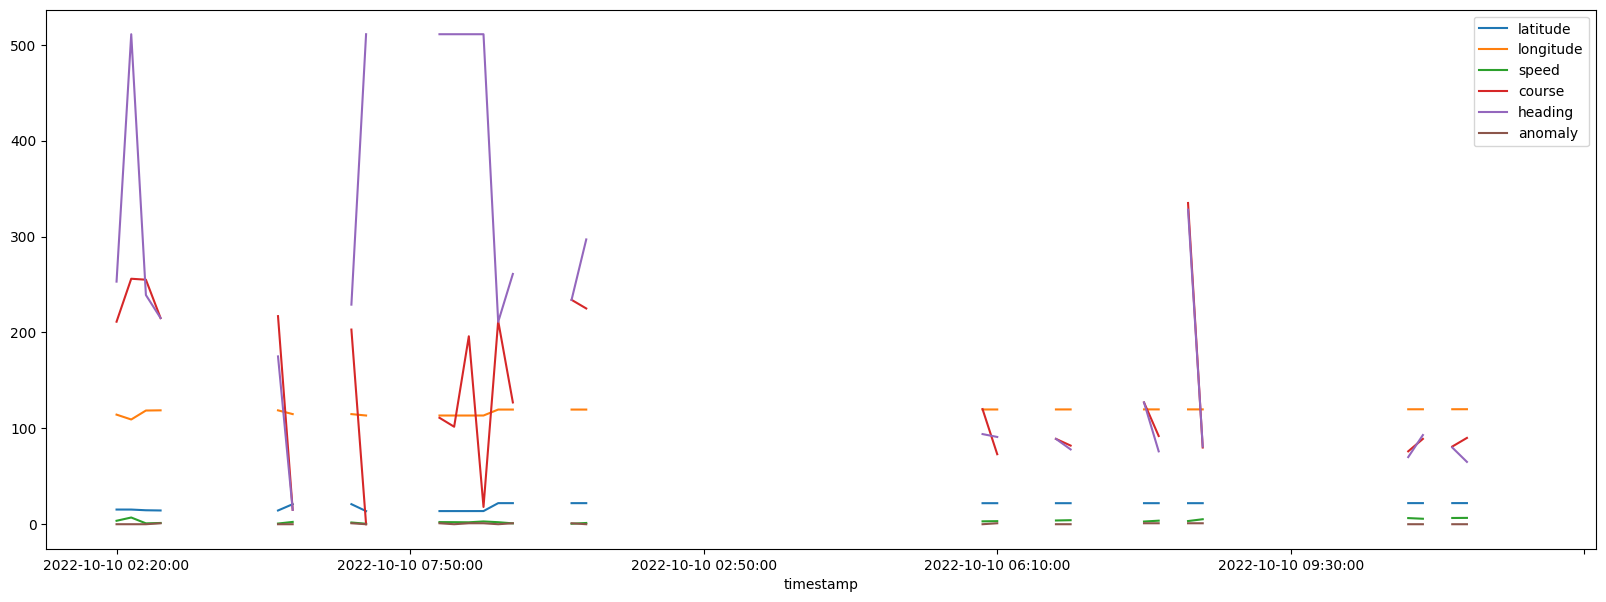

In [6]:
# Plot the first 100 rows of the dataset
df.head(100).plot(figsize=(20, 7))
plt.show()

In [7]:
df = df.dropna()

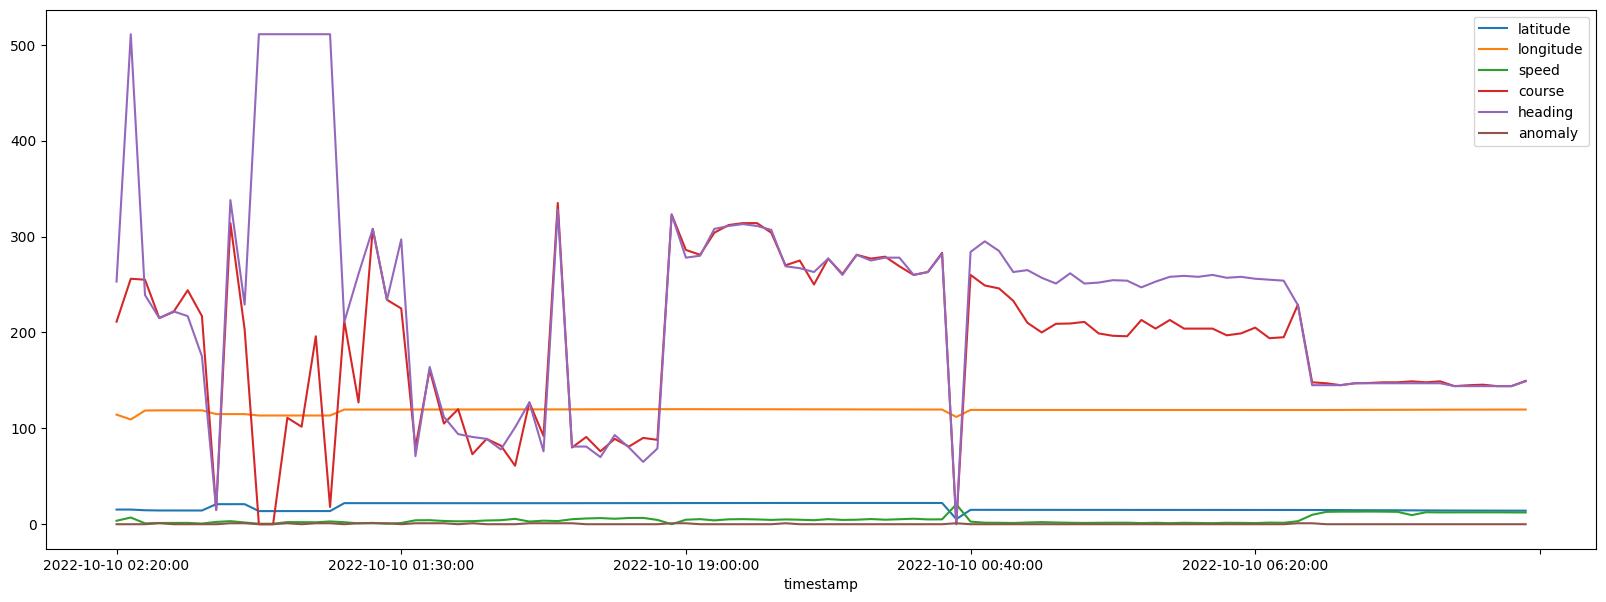

In [8]:
df.head(100).plot(figsize=(20, 7))
plt.show()

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53922 entries, 2022-10-10 02:20:00 to 2022-10-10 12:40:00
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   53922 non-null  float64
 1   longitude  53922 non-null  float64
 2   speed      53922 non-null  float64
 3   course     53922 non-null  float64
 4   heading    53922 non-null  float64
 5   anomaly    53922 non-null  float64
dtypes: float64(6)
memory usage: 2.9+ MB


In [10]:
df.head()


,latitude,longitude,speed,course,heading,anomaly
timestamp,,,,,,
2022-10-10 02:20:00,15.300092,114.284927,3.600000,211.200000,253.0,0.0
2022-10-10 00:50:00,15.295000,109.223333,7.000000,256.000000,511.0,0.0
2022-10-10 10:10:00,14.555212,118.568930,0.900000,255.000000,239.0,0.0
2022-10-10 10:20:00,14.331180,118.768095,1.300000,215.000000,215.0,1.0
2022-10-10 10:40:00,14.326155,118.765217,1.333333,221.333333,222.0,0.0


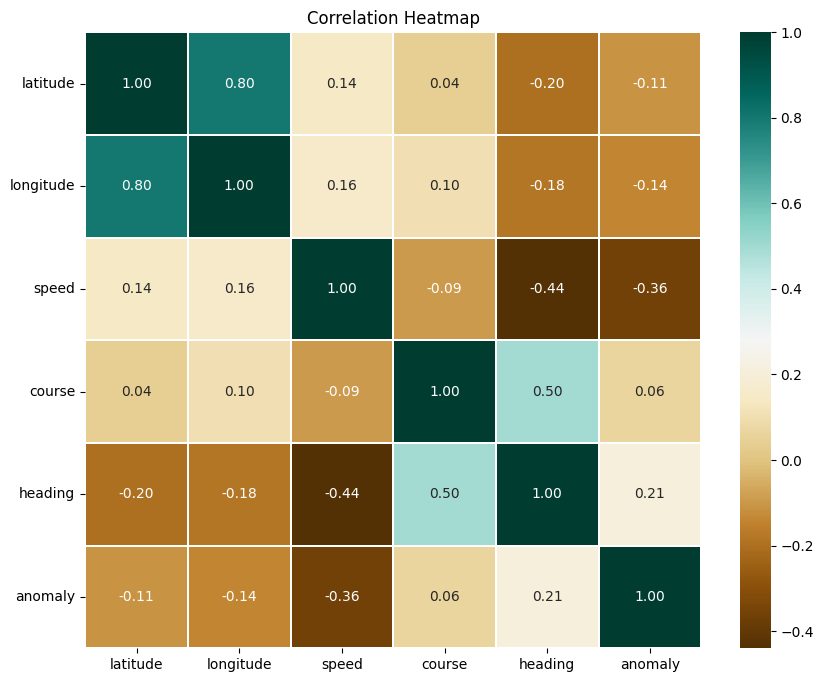

In [11]:
# Explore the correlation between metals
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
import seaborn as sns
sns.heatmap(correlation_matrix, annot=True, cmap='BrBG', linewidths=0.25, fmt=".2f", square=True)
plt.yticks(rotation=0)
plt.title('Correlation Heatmap')
plt.show()

In [12]:
df = df.dropna()

In [13]:
df.head()

,latitude,longitude,speed,course,heading,anomaly
timestamp,,,,,,
2022-10-10 02:20:00,15.300092,114.284927,3.600000,211.200000,253.0,0.0
2022-10-10 00:50:00,15.295000,109.223333,7.000000,256.000000,511.0,0.0
2022-10-10 10:10:00,14.555212,118.568930,0.900000,255.000000,239.0,0.0
2022-10-10 10:20:00,14.331180,118.768095,1.300000,215.000000,215.0,1.0
2022-10-10 10:40:00,14.326155,118.765217,1.333333,221.333333,222.0,0.0


In [14]:
original_df = df

In [15]:
df = df.drop(['course', 'heading'], axis=1)

In [16]:
df.head()

,latitude,longitude,speed,anomaly
timestamp,,,,
2022-10-10 02:20:00,15.300092,114.284927,3.600000,0.0
2022-10-10 00:50:00,15.295000,109.223333,7.000000,0.0
2022-10-10 10:10:00,14.555212,118.568930,0.900000,0.0
2022-10-10 10:20:00,14.331180,118.768095,1.300000,1.0
2022-10-10 10:40:00,14.326155,118.765217,1.333333,0.0


In [17]:
features = ['latitude', 'longitude', 'speed']
df_features = df[features].copy()
df_features['anomaly'] = df['anomaly']
print(df_features.head())
print(df_features.index)

                      latitude   longitude     speed  anomaly
timestamp                                                    
2022-10-10 02:20:00  15.300092  114.284927  3.600000      0.0
2022-10-10 00:50:00  15.295000  109.223333  7.000000      0.0
2022-10-10 10:10:00  14.555212  118.568930  0.900000      0.0
2022-10-10 10:20:00  14.331180  118.768095  1.300000      1.0
2022-10-10 10:40:00  14.326155  118.765217  1.333333      0.0
Index(['2022-10-10 02:20:00', '2022-10-10 00:50:00', '2022-10-10 10:10:00',
       '2022-10-10 10:20:00', '2022-10-10 10:40:00', '2022-10-10 11:10:00',
       '2022-10-10 11:40:00', '2022-10-10 06:10:00', '2022-10-10 06:30:00',
       '2022-10-10 06:50:00',
       ...
       '2022-10-10 10:30:00', '2022-10-10 19:20:00', '2022-10-10 20:10:00',
       '2022-10-10 20:40:00', '2022-10-10 21:20:00', '2022-10-10 21:40:00',
       '2022-10-10 22:00:00', '2022-10-10 22:30:00', '2022-10-10 23:00:00',
       '2022-10-10 12:40:00'],
      dtype='object', name='timestamp'

# Scaling and Input sequence creation

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Assuming 'df_features' is your DataFrame
features = ['latitude', 'longitude', 'speed', 'anomaly']
df_scaled = MinMaxScaler().fit_transform(df_features)

In [19]:


# Convert the time series data into sequences with target values
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:(i + n_steps), :])  # Include all features in the input sequence
        y.append(data[i + n_steps, -1])  # Target is 'Nickel'
    return np.array(X), np.array(y)


# Set the number of time steps for the LSTM model
n_steps = 3 # You can adjust this based on your data and requirements

# Create sequences for training
X, y = create_sequences(df_scaled, n_steps)

# Reshape input data to be 3D [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.3, shuffle=False)
X_cv, X_test, y_cv, y_test = train_test_split(X_, y_, test_size=0.5, shuffle=False)

# Building the Model (eg -LSTM with Attention)

In [20]:
# Build the LSTM model with attention
input_seq = Input(shape=(n_steps, len(features)))
lstm_out = LSTM(64, return_sequences=True)(input_seq)
dropout_1 = Dropout(0.2)(lstm_out)
lstm_out = LSTM(64, return_sequences=True)(dropout_1)
dropout_2 = Dropout(0.1)(lstm_out)
lstm_out = LSTM(64, return_sequences=True)(dropout_2)
dropout_3 = Dropout(0.06)(lstm_out)

# Attention mechanism
attention = Dense(1, activation='tanh')(dropout_3)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(64)(attention)
attention = Permute([2, 1])(attention)
sent_representation = multiply([dropout_3, attention])
sent_representation = Lambda(lambda xin: tf.keras.backend.sum(xin, axis=-2), output_shape=(64,))(sent_representation)

output = Dense(1)(sent_representation)

model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer='adam', loss='mae')


In [21]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 3, 4)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 3, 64)     │     17,664 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 3, 64)     │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 3, 64)     │     33,024 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 3, 64)     │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 3, 64)     │     33,024 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 3, 64)     │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 3, 1)      │         65 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 3)         │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 3)         │          0 │ flatten[0][0]     │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector       │ (None, 64, 3)     │          0 │ activation[0][0]  │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ permute (Permute)   │ (None, 3, 64)     │          0 │ repeat_vector[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 3, 64)     │          0 │ dropout_2[0][0],  │
│                     │                   │            │ permute[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ multiply[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 83,842 (327.51 KB)

 Trainable params: 83,842 (327.51 KB)

 Non-trainable params: 0 (0.00 B)

# Training the Model

In [22]:
# Train the model
history = model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.0970 - val_loss: 0.1213
Epoch 2/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0944 - val_loss: 0.1068
Epoch 3/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 19s 16ms/step - loss: 0.0822 - val_loss: 0.1009
Epoch 4/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 0.0855 - val_loss: 0.1004
Epoch 5/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0824 - val_loss: 0.1001
Epoch 6/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0828 - val_loss: 0.0982
Epoch 7/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0798 - val_loss: 0.0971
Epoch 8/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0796 - val_loss: 0.0987
Epoch 9/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0805 - val_loss: 0.0962
Epoch 10/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0812 - val_loss: 0.0982
Epoch 11/25
1180/1180 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0795 - val_loss: 0.0963
Epoch 12/25
1180/1180 

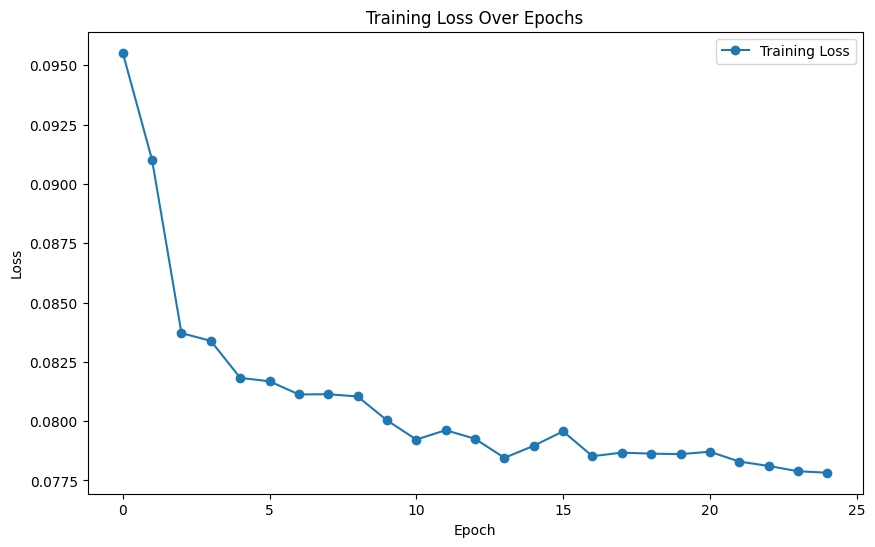

In [23]:
# Extract training loss from the history
train_loss_history = history.history['loss']

# Plot the training loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Training Loss', marker='o')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Prediction

In [24]:
# Make predictions on the test set
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

1180/1180 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
253/253 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


#Loss Evaluation

In [25]:
# Evaluate the model on the training set
train_loss = model.evaluate(X_train, y_train, verbose=0)
print(f'Training Loss: {train_loss}')
# Evaluate the model on the test set
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Training Loss: 0.07714011520147324
Test Loss: 0.09572885930538177


# Inverse Scaling

In [26]:

# Reverse the scaling of test_predictions and y_test
test_predictions = MinMaxScaler().fit(df_features['anomaly'].values.reshape(-1, 1)).inverse_transform(test_predictions)
y_test = MinMaxScaler().fit(df_features['anomaly'].values.reshape(-1, 1)).inverse_transform(y_test.reshape(-1, 1))

# Create a DataFrame for the test predictions
test_prediction_dates = df_features.index[-len(y_test):]
test_prediction_df = pd.DataFrame({'anomaly_Predicted': test_predictions.flatten()}, index=test_prediction_dates)

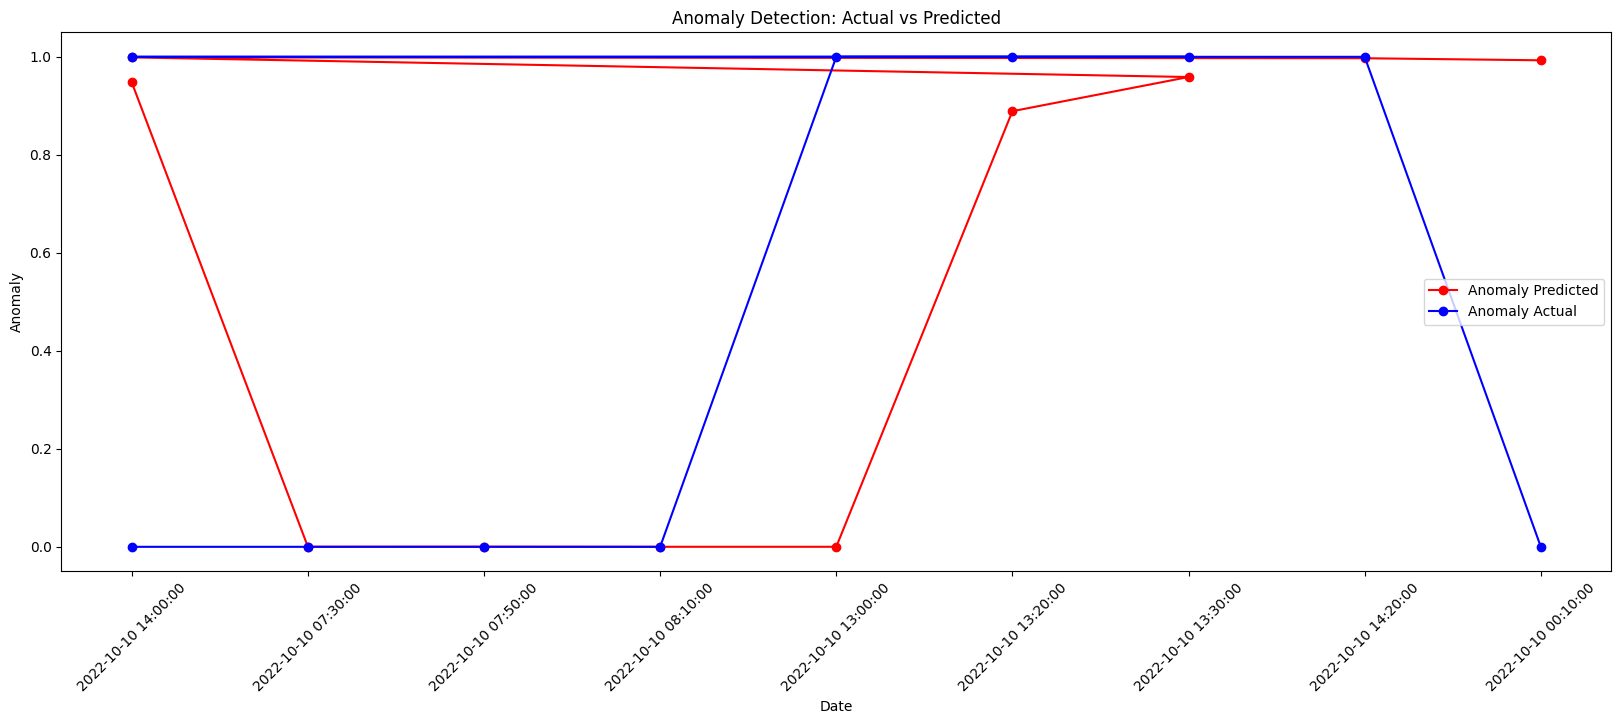

In [27]:
# Plot the actual and predicted values for the first 10 rows
plt.figure(figsize=(20, 7))
plt.plot(test_prediction_df.index[:10], test_prediction_df['anomaly_Predicted'][:10], marker='o', label='Anomaly Predicted', color='red')
plt.plot(test_prediction_df.index[:10], y_test[:10], marker='o', label='Anomaly Actual', color='blue')
plt.title('Anomaly Detection: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Anomaly')
plt.xticks(rotation=45)
plt.legend()
plt.show()



In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, test_predictions)
mse = mean_squared_error(y_test, test_predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")

Mean Absolute Error (MAE): 0.09572885162791149
Mean Squared Error (MSE): 0.08765060695552752


```markdown
# Project Explanation

## Overview
This project focuses on anomaly detection in time series data using a Long Short-Term Memory (LSTM) network with an attention mechanism. The dataset consists of various features such as latitude, longitude, speed, and anomaly status, collected over time.

## Data Preprocessing
1. **Loading Data**: The dataset is loaded and set with a timestamp index.
2. **Handling Missing Values**: Missing values are dropped to ensure data integrity.
3. **Feature Selection**: Relevant features (`latitude`, `longitude`, `speed`, `anomaly`) are selected for the model.
4. **Scaling**: Data is scaled using MinMaxScaler to normalize the feature values.

## Sequence Creation
- **Time Steps**: The data is converted into sequences with a specified number of time steps (`n_steps = 3`). This helps the LSTM model to learn temporal dependencies.
- **Train-Test Split**: The data is split into training, cross-validation, and test sets.

## Model Building
### LSTM with Attention
- **LSTM Layers**: Three LSTM layers are used to capture the temporal dependencies in the data. Dropout layers are added to prevent overfitting.
- **Attention Mechanism**: An attention layer is added to focus on the most relevant parts of the input sequence. This helps the model to weigh the importance of different time steps differently.
- **Output Layer**: A Dense layer is used to produce the final output.

### Model Compilation
- **Optimizer**: Adam optimizer is used for training.
- **Loss Function**: Mean Absolute Error (MAE) is used as the loss function.

## Training
- The model is trained for 25 epochs with a batch size of 32. The training process is monitored using the validation data.

## Evaluation
- **Loss Evaluation**: The model's performance is evaluated using MAE and Mean Squared Error (MSE) on both training and test sets.
- **Inverse Scaling**: The predictions are inverse scaled to match the original data scale.

## Visualization
- **Training Loss**: The training loss over epochs is plotted to visualize the model's learning process.
- **Predictions**: Actual vs. predicted anomaly values are plotted to assess the model's performance.

## Conclusion
This project demonstrates the use of LSTM with attention for anomaly detection in time series data. The attention mechanism helps the model to focus on important time steps, improving its predictive performance.
### Why LSTM?
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that are well-suited for sequence prediction problems. They are capable of learning long-term dependencies, which is crucial for time series data where the context from previous time steps can significantly impact the prediction at the current time step. LSTMs address the vanishing gradient problem that traditional RNNs face, making them more effective for capturing temporal dependencies in data. In this project, LSTMs are used to model the sequential nature of the anomaly detection data, allowing the network to learn patterns and detect anomalies over time.
### Why LSTM with Attention Mechanism?
The attention mechanism enhances the LSTM model by allowing it to focus on the most relevant parts of the input sequence. This is particularly useful in time series data where certain time steps may be more important than others for making predictions. By assigning different weights to different time steps, the attention mechanism helps the model to better capture the temporal dependencies and improve its predictive performance. This combination of LSTM and attention mechanism results in a more robust and accurate anomaly detection model.
### Optimization Strategies

1. **Hyperparameter Tuning**: Experiment with different hyperparameters such as the number of LSTM units, dropout rates, batch size, and learning rate. Use techniques like Grid Search or Random Search to find the optimal set of hyperparameters.

2. **Early Stopping**: Implement early stopping to prevent overfitting. Monitor the validation loss and stop training when the loss stops improving.

3. **Learning Rate Scheduler**: Use a learning rate scheduler to adjust the learning rate during training. This can help the model converge faster and avoid local minima.

4. **Regularization**: Add L2 regularization to the LSTM layers to prevent overfitting.

5. **Data Augmentation**: If applicable, augment the data to increase the diversity of the training set and improve the model's generalization.

6. **Feature Engineering**: Create new features or transform existing ones to provide more relevant information to the model.

7. **Model Architecture**: Experiment with different model architectures, such as adding more LSTM layers, using Bidirectional LSTMs, or trying other types of recurrent layers like GRU.

8. **Ensemble Methods**: Combine predictions from multiple models to improve overall performance. This can be done by averaging predictions or using a more sophisticated ensemble technique.

9. **Cross-Validation**: Use k-fold cross-validation to ensure the model's performance is consistent across different subsets of the data.

10. **Batch Normalization**: Add batch normalization layers to stabilize and accelerate the training process.

By implementing these optimization strategies, you can improve the performance and robustness of your anomaly detection model.
### Why CNN?
Convolutional Neural Networks (CNNs) are typically used for image data, but they can also be applied to time series data by treating the time series as a one-dimensional image. CNNs can capture local patterns and features in the data through convolutional layers, which can be beneficial for anomaly detection. By using CNNs, you can leverage their ability to automatically learn spatial hierarchies of features, which can improve the model's performance in detecting anomalies.

### Combining CNN with LSTM
Combining CNN with LSTM can optimize the model by leveraging the strengths of both architectures. CNN layers can be used to extract local features from the time series data, which are then fed into LSTM layers to capture temporal dependencies. This hybrid approach can enhance the model's ability to detect complex patterns and anomalies in the data.

### Implementation
1. **CNN Layers**: Add convolutional layers to extract features from the input sequences.
2. **LSTM Layers**: Use LSTM layers to capture temporal dependencies in the extracted features.
3. **Attention Mechanism**: Optionally, add an attention mechanism to focus on the most relevant parts of the input sequence.
4. **Output Layer**: Use a Dense layer to produce the final output.
# Predict Oil Spill Using Image Classification

## Image Preprocessing
1. **Loading Images**: Load the images corresponding to the predicted coordinates.
2. **Resizing and Normalizing**: Resize the images to the input size required by the image classification model and normalize the pixel values.

## Image Classification Model
- **Pre-trained Model**: Use a pre-trained Convolutional Neural Network (CNN) model such as ResNet50, VGG16, or InceptionV3 for image classification.
- **Fine-tuning**: Fine-tune the pre-trained model on a dataset of labeled images indicating the presence or absence of oil spills.

## Prediction
1. **Load Pre-trained Model**: Load the fine-tuned pre-trained model.
2. **Predict Oil Spill**: Use the model to predict the presence of oil spills in the preprocessed images.
### Why LSTM?
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) that are well-suited for sequence prediction problems. They are capable of learning long-term dependencies, which is crucial for time series data where the context from previous time steps can significantly impact the prediction at the current time step. LSTMs address the vanishing gradient problem that traditional RNNs face, making them more effective for capturing temporal dependencies in data. In this project, LSTMs are used to model the sequential nature of the anomaly detection data, allowing the network to learn patterns and detect anomalies over time.    

## Implementation
```